# Advanced Lane Finding

The purpose of this code is to detect lanelines in the given video.


The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


We will start by importing all relevant libraries such as opencv, numpy required.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

## Read Pickle containing data saved from pipeline


There are two main steps to this process: use chessboard images to obtain image points and object points, and then use the OpenCV functions [**cv2.calibrateCamera()**](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) and [**cv2.undistort()**](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners) to compute the calibration and undistortion.

In [2]:
dist_pickle = pickle.load( open( "pickle/test_images_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

## Include relevant functions from the developed pipeline

We are including here only the relevant functions from our pipeline in the previous project. This will include the hue, saturation, x gradient and combined thresholding functions.

If we decide to change the image processing options and include other thresholds as well, we will enter them in the future in this box.

In [3]:
# Thresholding functions
# since we have evaludated earlier that HLS gives good image filtering results
# only included the relevant thresholding functions from "pipeline.ipynb"

def lightness_select(img, thresh = (120,255)):
    
    # 1. Convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2. Apply threshold to s channel
    l_channel = hls[:,:,1]
    # 3. Create empty array to store the binary output and apply threshold
    lightness_image = np.zeros_like(l_channel)
    lightness_image[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1

    return lightness_image

def saturation_select(img, thresh = (100,255)):

    # 1. convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2. apply threshold to s channel
    s_channel = hls[:,:,2]
    # 3. create empty array to store the binary output and apply threshold
    sat_image = np.zeros_like(s_channel)
    sat_image[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return sat_image


def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0,255)):

    # 1. Applying the Sobel depending on x or y direction and getting the absolute value
    if (orient == 'x'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if (orient == 'y'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 2. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 3. Create mask of '1's where the sobel magnitude is > thresh_min and < thresh_max
    sobel_image = np.zeros_like(scaled_sobel)
    sobel_image[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sobel_image


# More threhsolding functions can be added here from the pipeline for advacned filtering options

## Combined Thresholding

In the next step, we apply combined thresholding from our thresholding functions in the previous box. For details, refer to "pipeline.ipynb".


In [4]:
### Combined Thresholding Function
def combined_threshold(img):

    # convert to hls format and extract channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # applying thresholding and storing different filtered images
    l_binary = lightness_select(img, thresh = (120, 255))
    s_binary = saturation_select(img, thresh = (100, 255))

    ksize = 9
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))

    # creating an empty binary image
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((gradx == 1) | (s_binary == 1)) & ((l_binary == 1) & (s_binary == 1))] = 1

    # apply region of interest mask
    height, width = combined_binary.shape
    mask = np.zeros_like(combined_binary)
    region = np.array([[0, height-1], [int(width/2), int(height/2)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region], 1)

    masked_binary = cv2.bitwise_and(combined_binary, mask)

    return masked_binary

## Perspective Transform

We apply the perspective transform using [**cv2.getPerspectiveTransform(src, dst)**](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#getperspectivetransform).

This function converts our camera view of the lanelines to a top-down view or a bird's eye view. We will use the image generated by this function for identifying lanelines and estimating the road curvatures.

In [5]:
# function for applying perspective view on the masked thresholded images
def perspective_view(img):
    img_size = (img.shape[1], img.shape[0])
    # image points extracted from image approximately
    bottom_left = [210, 720]
    bottom_right = [1100, 720]
    top_left = [570, 470]
    top_right = [720, 470]
    src = np.float32([bottom_left, bottom_right, top_right, top_left])
    pts = np.array([bottom_left, bottom_right, top_right, top_left])
    pts = pts.reshape((-1, 1, 2))
    # choose four points in warped image so that the lines should appear as parallel
    bottom_left_dst = [320, 720]
    bottom_right_dst = [920, 720]
    top_left_dst = [320, 1]
    top_right_dst = [920, 1]
    dst = np.float32([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])
    # apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # warp the image using perspective transform M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

## Pipeline

Here we will work on developing a pipeline for processing individual images for detecting, visualizing lanelines and calculate the radius of curvature for lanelines.

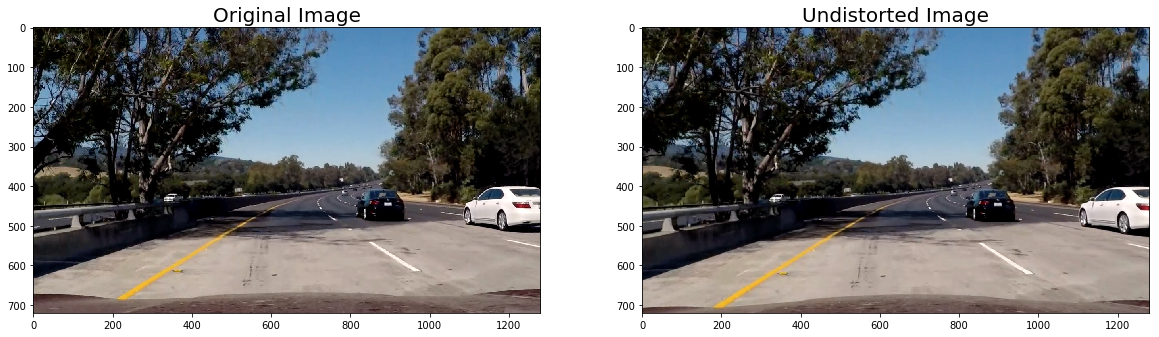

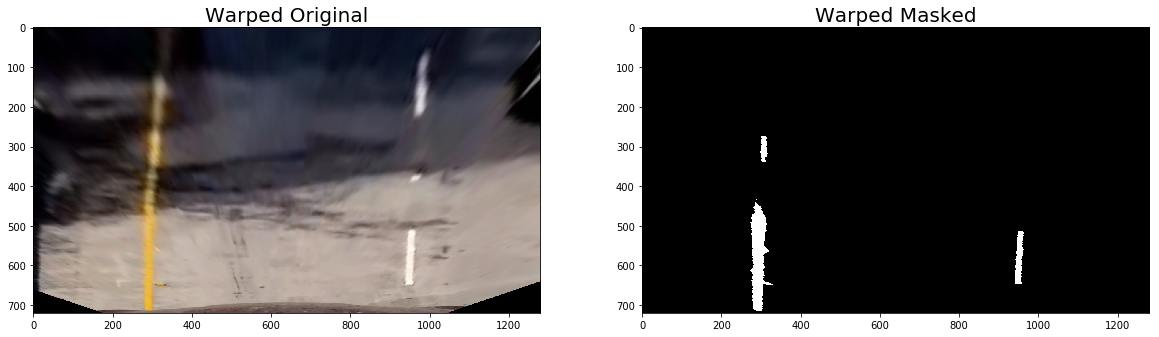

In [6]:
# read in an image
img = mpimg.imread("test_images/test5.jpg")

# undistort the original image using stored values from pickle
undist_original = cv2.undistort(img, mtx, dist, None, mtx)

# apply perspective view on the image
warped_original, M, Minv = perspective_view(undist_original)

# apply combined threshold
combined_threshold = combined_threshold(undist_original)

# apply perspective transform on the thresholded image
warped, M, Minv = perspective_view(combined_threshold)

plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_original)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

plt.figure(2)
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(warped_original)
ax3.set_title('Warped Original', fontsize=20)
ax4.imshow(warped, cmap = 'gray')
ax4.set_title('Warped Masked', fontsize=20)
plt.show()